In [1]:
import numpy as np
import pandas as pd
import time as tm
import math # to calculate distance between servers

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA # use pca reduce dims
from mpl_toolkits.mplot3d import Axes3D # plot 3d figure
from s_dbw import S_Dbw # evaluate clustering

from matplotlib import pyplot

from sklearn.cluster import MeanShift # a clustering algorithm decide the n_cluster automatically

import seaborn as sns # plot heatmap

In [2]:
# Data Processing - read data from .csv file

data_loc = 'us'
file = f'../dataset/{data_loc}.csv'

df = pd.read_csv(file)
df = pd.DataFrame(df)

time_start = tm.time()

ip_time = dict()
special_chr = ["{", "}", "'", ":", " "]

for i in range(len(df)):
    raw_points = df['transactionList'][i]
    points = ''.join(e for e in raw_points if e not in special_chr)
    points = points.split(",")
    for j in range(len(points)):
        time = points[j][:17]
        ip = points[j][17:]
        if ip not in ip_time:
            ip_time[ip] = [time]
        else:
            ip_time[ip].append(time)

time_end = tm.time()
runtime = time_end - time_start
print(f'runtime: {runtime} second')

total_num = len(ip_time)
print(f'num of total server: {total_num}')

print(f'Data Size of "{data_loc}": {len(df)}')

C:\Users\smart\AppData\Local\Temp\ipykernel_5828\901789945.py:6: DtypeWarning: Columns (1,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


runtime: 37.40006732940674 second
num of total server: 619
Data Size of "us": 284249


In [3]:
# select specific period from the dataset, "ip_time"

def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

# get 2021 data - US-All
data_us_all = get_ip_time()

# get US-1 data - 2021-05-07~2021-05-16 (for us dataset)
us_1 = ['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
            '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16']
data_us_1 = get_ip_time(period=us_1)

# get US-0 data - 2021-04-29~2021-05-05 (for us dataset)
us_0 = ['2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03',
        '2021-05-04', '2021-05-05']
data_us_0 = get_ip_time(period=us_0)

dates = [us_0, us_1]

# check the data
for ip in data_us_1:
    print(f'ip: {ip}')
    print(data_us_1[ip][:5])
    break

ip: 52.223.228.27
['2021-05-07T000111', '2021-05-07T002416', '2021-05-07T003212', '2021-05-07T002644', '2021-05-07T003952']


In [4]:
# setup hour axis for below chart
hour_axis = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [5]:
# Table 5.1: Estimation model - Error Rate

print('The results of Table 5.1 are in the folder ./ch5_CJS_Estimation_Error/ch5.1_Preliminaries/p2_est_result')
print('Table 5.1: Estimation model - Error Rate')

The results of Table 5.1 are in the folder ./ch5_CJS_Estimation_Error/ch5.1_Preliminaries/p2_est_result
Table 5.1: Estimation model - Error Rate


In [6]:
# define the k-means clustering function

def kmeans_cluster(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model) # len(yhat) = num of ip
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score

hour_period = []
def kmeans_cluster_3d(model, n_clusters=2, pca_components=False, hour_period=hour_period, plot=False, show_centers=False):
    model_3d = model
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model) # len(yhat) = num of ip
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        fig = pyplot.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
        ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
        ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')
        
        clusters = np.unique(yhat)
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            ax.scatter(model_3d[row_ix, 0], model_3d[row_ix, 1], model_3d[row_ix, 2], color=colors[cluster])
        pyplot.show()

    score = S_Dbw(model, yhat)
    return yhat, score

def get_ip_periods_count(ip, ip_time, hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]:
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
                continue
    return hour_count

number of ip in each cluster
{0: 569, 1: 10, 2: 31}


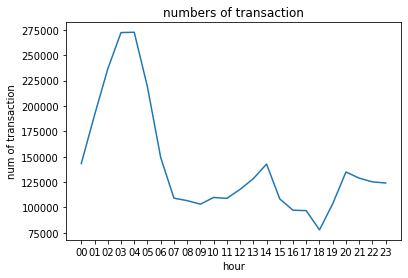

cluster 2



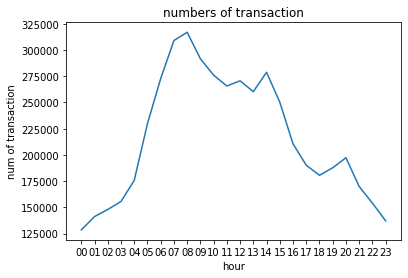

cluster 0 + cluster 1

Figure 5.1: Transaction Counts in Different Clusters - K-Means with US-All


In [7]:
# Figure 5.1: Transaction Counts in Different Clusters - K-Means with US-All

data_choose = data_us_all

# clustering parameters
n_periods = 3 # how many attributes
slide_hour = 0 # change attributes by sliding time windows
num_clusters = 3
pca_choose = 2

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# clustering
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

# the thesis swap cluster-0 to cluster-2 
yhat_count_hour3
unique, counts = np.unique(yhat_count_hour3, return_counts=True)
print('number of ip in each cluster')
print(dict(zip(unique, counts)))

# transaction count
hour_transaction_count_c2 = dict()
hour_transaction_count_c01 = dict()

for i in range(len(ip_index)):
    ip = ip_index[i]
    if yhat_count_hour3[i] == 0:
        for time in data_choose[ip]:
            hour = time[11:13]
            if hour not in hour_transaction_count_c2:
                hour_transaction_count_c2[hour] = 1
            else: hour_transaction_count_c2[hour] += 1
    elif yhat_count_hour3[i] == 1 or yhat_count_hour3[i] == 2:
        for time in data_choose[ip]:
            hour = time[11:13]
            if hour not in hour_transaction_count_c01:
                hour_transaction_count_c01[hour] = 1
            else: hour_transaction_count_c01[hour] += 1

trans_count_axis_c2 = list()
trans_count_axis_c01 = list()
for key in hour_axis:
    trans_count_axis_c2.append(hour_transaction_count_c2[key])
    trans_count_axis_c01.append(hour_transaction_count_c01[key])

pyplot.title(f'numbers of transaction')
pyplot.xlabel('hour')
pyplot.ylabel('num of transaction')
pyplot.plot(hour_axis, trans_count_axis_c2)
pyplot.show()
print('cluster 2\n')

pyplot.title(f'numbers of transaction')
pyplot.xlabel('hour')
pyplot.ylabel('num of transaction')
pyplot.plot(hour_axis, trans_count_axis_c01)
pyplot.show()
print('cluster 0 + cluster 1')

print('\nFigure 5.1: Transaction Counts in Different Clusters - K-Means with US-All')

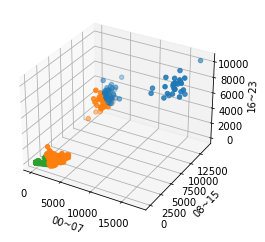

n_cluster=3



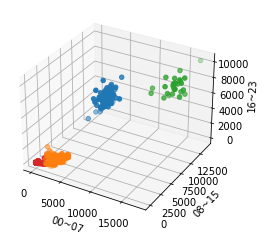

n_cluster=4
Figure 5.2: Clustering Again in K-Means Cluster-2


In [8]:
# Figure 5.2: Clustering Again in K-Means Cluster-2

data_choose = data_us_all

# clustering parameters
n_periods = 3 # how many attributes
slide_hour = 0 # change attributes by sliding time windows
num_clusters = 3
pca_choose = 2

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# clustering with the whole data
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

# clustering with cluster-2
count_period3_c2 = []
for i in range(len(yhat_count_hour3)):
    cluster = yhat_count_hour3[i]
    if cluster == 0:
        count_period3_c2.append(count_period3[i])
X_count_hour3_c2 = np.array(count_period3_c2)

yhat, score = kmeans_cluster_3d(model=X_count_hour3_c2, n_clusters=3, pca_components=2, hour_period=hour_period, plot=True, show_centers=False)
print('n_cluster=3\n')

yhat, score = kmeans_cluster_3d(model=X_count_hour3_c2, n_clusters=4, pca_components=2, hour_period=hour_period, plot=True, show_centers=False)
print('n_cluster=4')

print('Figure 5.2: Clustering Again in K-Means Cluster-2')

In [9]:
# Table 5.2: Subnets in Each Cluster - K-Means with US-All

# the cluster number has been re-arranged in the thesis

data_choose = data_us_all

# clustering parameters
n_periods = 3 # how many attributes
slide_hour = 0 # change attributes by sliding time windows
num_clusters = 3
pca_choose = 2

# set hour periods for attributes
period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

# clustering with the whole data
count_period3 = [] # [period1, period2, period3]
ip_index = [] # for finding the correponding ip in the future
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period3.append(period3)
    ip_index.append(_ip)
X_count_hour3 = np.array(count_period3)
yhat, score = kmeans_cluster(X_count_hour3, n_clusters=num_clusters, pca_components=pca_choose, plot=False, show_centers=False)

class_subnet = dict()
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    for i in row_ix[0]:
        subnet = ip_index[i][:10]
        if yhat[i] not in class_subnet:
            class_subnet[yhat[i]] = {subnet: [ip_index[i]]}
        elif subnet not in class_subnet[yhat[i]]:
            class_subnet[yhat[i]][subnet] = [ip_index[i]]
        elif ip_index[i] not in class_subnet[yhat[i]][subnet]:
            class_subnet[yhat[i]][subnet].append(ip_index[i])
for _class in class_subnet:
    print(f'\ncluster {_class}')
    for key, value in class_subnet[_class].items():
        print(f'{key}: {len(value)}')

print('\nTable 5.2: Subnets in Each Cluster - K-Means with US-All')


cluster 0
52.223.228: 21
52.223.227: 30
52.223.226: 74
52.223.244: 71
99.181.97.: 83
192.16.65.: 82
52.223.247: 3
52.223.246: 35
52.223.225: 34
52.223.224: 19
52.223.243: 97
52.223.229: 12
99.181.65.: 1
99.181.96.: 6
52.223.248: 1

cluster 1
99.181.96.: 10

cluster 2
52.223.228: 28
52.223.227: 3

Table 5.2: Subnets in Each Cluster - K-Means with US-All


In [10]:
# 5.2 CJS with Multiple K-Means Clustering Results

In [11]:
# define kmeans_cluster_random for producing random k-means results

def kmeans_cluster_random(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             #random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model)
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score # len(yhat) = num of ip

In [12]:
# get_csv: output each clustering result into .csv file
# output_s_dbw_record: s_dbw scores of all the clustering results into .csv file

def get_csv(yhat, ip_index, n_clusters, label):
    n_clusters = len(np.unique(yhat))
    ip_class = []
    for i in range(len(ip_index)):
        _class = f'class{yhat[i]}'
        ip_class.append([_class, ip_index[i]])
    
    df_class = pd.DataFrame(ip_class, columns=['class', 'ip'])
    file_name = f'./CJS_results/{data_loc}/p0_cluster_result/n_cluster_{n_clusters}/label_{label}.csv'
    df_class.to_csv(file_name)
    return 0

def output_s_dbw_record(record):
    df_class = pd.DataFrame(record, columns=['n_cluster', 'label', 'S_Dbw']) # add 'n_cluster'
    file_name = f'./CJS_results/{data_loc}/p0_cluster_result/s_dbw_record.csv'
    df_class.to_csv(file_name)
    return 0

In [13]:
# produce random k-means results

# Code here show how to generate k-means results. However, it does not actually generate k-means results

# To generate k-means results:
# 1. set "number_results_each_n_cluster" to the number of clustering results you want to produce in each n_cluster
# 2. remove "#" in front of "output_s_dbw_record"

number_results_each_n_cluster = 0 

n_periods = 3
slide_hour = 0

period_len = len(hour_axis)//n_periods
hour_period = [] # feature
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

print(f'hour_period: {hour_period}')

count_period = []
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period.append(period3)
    ip_index.append(_ip)
X_count_hour = np.array(count_period)

s_dbw_record = []
for num_clusters in range(2,9):
    print(f'num_clusters={num_clusters}')
    for label in range(number_results_each_n_cluster):
        yhat_count_hour, score_count_hour = kmeans_cluster_random(X_count_hour, n_clusters=num_clusters, pca_components=2, plot=False, show_centers=False)
        get_csv(yhat=yhat_count_hour, ip_index=ip_index, n_clusters=num_clusters, label=label)
        s_dbw_record.append([num_clusters, label, score_count_hour]) # columns=['n_cluster', 'label', 'S_Dbw']

# ouput s_dbw_record
# output_s_dbw_record(s_dbw_record)
print('fininsh output s_dbw file')

hour_period: [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]
num_clusters=2
num_clusters=3
num_clusters=4
num_clusters=5
num_clusters=6
num_clusters=7
num_clusters=8
fininsh output s_dbw file


In [14]:
# Ch 5.2.1 Clustering Result with US-1 - May 07 to May 16


us_period_1

n_cluster: 2
number of error rate > inf: 0
number of nan: 0

n_cluster: 3
number of error rate > inf: 0
number of nan: 0

n_cluster: 4
number of error rate > inf: 0
number of nan: 0

n_cluster: 5
number of error rate > inf: 0
number of nan: 0

n_cluster: 6
number of error rate > inf: 0
number of nan: 0

n_cluster: 7
number of error rate > inf: 0
number of nan: 0

n_cluster: 8
number of error rate > inf: 0
number of nan: 0


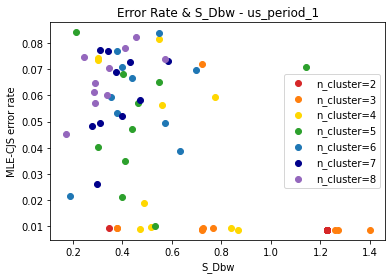

Figure 5.3: S_Dbw Score and Error Rate - US-1


In [15]:
# Figure 5.3: S_Dbw Score and Error Rate - US-1

loc_choose = 1
data_locs = ['us_period_0', 'us_period_1', 'France', 'Germany']
data_loc = data_locs[loc_choose]

print(f'\n{data_loc}')

# err > err_up_limit -> not write into record
err_up_limit = math.inf

err_record, std_record, time_record = [], [], []
for n_cluster in [2,3,4,5,6,7,8]:
    err_record.append([])
    std_record.append([])
    time_record.append([])
    for label in range(10):
        file_path = f'./CJS_results/{data_loc}/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record[-1].append(float(lines[-1][10:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record[-1].append(None)
            std_record[-1].append(None)
        else:
            err_record[-1].append(float(lines[0][5:]))
            std_record[-1].append(float(lines[1][5:]))
            
        
# s_dbw_record
s_dbw_record = []
s_dbw_file_path = f'./CJS_results/{data_loc}/p0_cluster_result/s_dbw_record.csv'
df_sdbw = pd.read_csv(s_dbw_file_path)
df_sdbw.head()
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record.append([])
    for label in range(10):
        s_dbw_record[-1].append(df_sdbw['S_Dbw'][n_cluster*10+label])

# scatter plot - Error Rate & S_Dbw

pyplot.title(f'Error Rate & S_Dbw - {data_loc}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('MLE-CJS error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    print(f'\nn_cluster: {_cluster}')
    num_over_err_up_limit = 0
    num_is_nan = 0
    for label in range(10):
        if err_record[n_cluster][label] is None:
            num_over_err_up_limit += 1
        elif np.isnan(err_record[n_cluster][label]):
            num_is_nan += 1
    print(f'number of error rate > {err_up_limit}: {num_over_err_up_limit}')
    print(f'number of nan: {num_is_nan}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.3: S_Dbw Score and Error Rate - US-1')

In [16]:
# Table 5.3: Correlation Matrix - US-1

print(f'err_up_limit: {err_up_limit}')
print(f'\n{data_loc}')
data_df = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(70)))

for n_cluster in [2,3,4,5,6,7,8]:
    for label in range(10):
        index = (n_cluster-2)*10+label
        data_df['n_cluster'][index] = n_cluster
        data_df['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
        data_df['err'][index] = err_record[n_cluster-2][label]
        data_df['std'][index] = std_record[n_cluster-2][label]
        data_df['CJS_time'][index] = time_record[n_cluster-2][label]
        if err_record[n_cluster-2][label] is None:
            print(f'err is None: n_cluster={n_cluster}, label={label}')
            data_df['err'][index] = 'None'
            data_df['std'][index] = 'None'
        elif np.isnan(err_record[n_cluster-2][label]):
            print(f'err is nan: n_cluster={n_cluster}, label={label}')
            data_df['err'][index] = 'None'
            data_df['std'][index] = 'None'
            
# Delete these row indexes from dataFrame
indexNames = data_df[ data_df['err'] == 'None' ].index
print(f'drop index: {indexNames}')
data_df.drop(indexNames , inplace=True)
km_data_df_us_1 = data_df # for ch5.3

data_df.head(20)
#print(data_df)
max_time = max(data_df['CJS_time'])
print(f'max CJS time: {max_time}')
print('\nTable 5.3: Correlation Matrix - US-1')

data_df.astype('float64').corr()

err_up_limit: inf

us_period_1
drop index: Int64Index([], dtype='int64')
max CJS time: 13.5825

Table 5.3: Correlation Matrix - US-1


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.714362,0.719256,0.678271,0.970779
S_Dbw,-0.714362,1.000000,-0.571743,-0.544228,-0.620324
err,0.719256,-0.571743,1.000000,0.994282,0.666139
std,0.678271,-0.544228,0.994282,1.000000,0.623519
CJS_time,0.970779,-0.620324,0.666139,0.623519,1.000000


In [17]:
# Table 5.4: Mean Value of S_Dbw and Error Rate with n_cluster=2 to 8

print(f'\n{data_loc}')
print(f'err_up_limit: {err_up_limit}')

for n_cluster in range(7):
    print(f'\nn_cluster: {n_cluster+2}')
    n_cluster_index = data_df[ data_df['n_cluster'] == n_cluster+2 ].index # because some index was drop (data_df['err'] == 'None')
    S_Dbw_mean = data_df['S_Dbw'][n_cluster_index].mean()
    err_mean = data_df['err'][n_cluster_index].mean()
    std_mean = data_df['std'][n_cluster_index].mean()
    time_mean = data_df['CJS_time'][n_cluster_index].mean()
    print(f'mean_S_Dbw: {round(S_Dbw_mean, 4)}')
    print(f'mean_err: {round(err_mean, 4)}')
    print(f'mean_std: {round(std_mean, 4)}')
    print(f'mean_CJS_time: {round(time_mean, 4)}')

print('\nTable 5.4: Mean Value of S_Dbw and Error Rate with n_cluster=2 to 8')


us_period_1
err_up_limit: inf

n_cluster: 2
mean_S_Dbw: 1.1379
mean_err: 0.0087
mean_std: 0.0064
mean_CJS_time: 1.2889

n_cluster: 3
mean_S_Dbw: 0.8343
mean_err: 0.0153
mean_std: 0.0188
mean_CJS_time: 1.8298

n_cluster: 4
mean_S_Dbw: 0.5669
mean_err: 0.0401
mean_std: 0.0707
mean_CJS_time: 3.0007

n_cluster: 5
mean_S_Dbw: 0.4849
mean_err: 0.0499
mean_std: 0.0864
mean_CJS_time: 4.8307

n_cluster: 6
mean_S_Dbw: 0.4583
mean_err: 0.0591
mean_std: 0.1052
mean_CJS_time: 6.6747

n_cluster: 7
mean_S_Dbw: 0.3792
mean_err: 0.0604
mean_std: 0.1068
mean_CJS_time: 9.1424

n_cluster: 8
mean_S_Dbw: 0.3398
mean_err: 0.0668
mean_std: 0.1179
mean_CJS_time: 12.2906

Table 5.4: Mean Value of S_Dbw and Error Rate with n_cluster=2 to 8


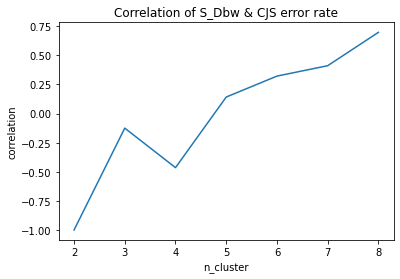

Figure 5.4: The Correlation of S_Dbw and Error Rate - US-1


In [18]:
# Figure 5.4: The Correlation of S_Dbw and Error Rate - US-1

correlation_sdbw_err, n_clusters = [], []
for n_cluster in range(7):
    n_clusters.append(n_cluster+2)
    corr = data_df[ data_df['n_cluster'] == n_cluster+2 ].astype('float64').corr()['S_Dbw']['err']
    correlation_sdbw_err.append(corr)

n_clusters = [2,3,4,5,6,7,8]
pyplot.title('Correlation of S_Dbw & CJS error rate')
pyplot.xlabel('n_cluster')
pyplot.ylabel('correlation')
pyplot.plot(n_clusters, correlation_sdbw_err)
pyplot.show()

print('Figure 5.4: The Correlation of S_Dbw and Error Rate - US-1')

In [19]:
# prepare calculate Std/Avg - number of servers

In [20]:
# caculate baseline - number of servers in one date

# period_0
ip_date_dict_p0 = dict()
for ip in data_us_0:
    for time in data_us_0[ip]:
        date = time[5:10]
        if date not in ip_date_dict_p0:
            ip_date_dict_p0[date] = [ip]
        elif ip not in ip_date_dict_p0[date]:
            ip_date_dict_p0[date].append(ip)
# baseline
baseline_ip_sum_p0 = []
for date in sorted(ip_date_dict_p0):
    print(date)
    baseline_ip_sum_p0.append(len(ip_date_dict_p0[date]))
print(f'baseline_ip_sum_p0: {baseline_ip_sum_p0}')
    
# period_1
ip_date_dict_p1 = dict()
for ip in data_us_1:
    for time in data_us_1[ip]:
        date = time[5:10]
        if date not in ip_date_dict_p1:
            ip_date_dict_p1[date] = [ip]
        elif ip not in ip_date_dict_p1[date]:
            ip_date_dict_p1[date].append(ip)
# baseline
baseline_ip_sum_p1 = []
for date in sorted(ip_date_dict_p1):
    print(date)
    baseline_ip_sum_p1.append(len(ip_date_dict_p1[date]))
print(f'baseline_ip_sum_p1: {baseline_ip_sum_p1}')


04-29
04-30
05-01
05-02
05-03
05-04
05-05
baseline_ip_sum_p0: [314, 314, 303, 321, 285, 313, 321]
05-07
05-08
05-09
05-10
05-11
05-12
05-13
05-14
05-15
05-16
baseline_ip_sum_p1: [499, 521, 485, 473, 492, 494, 492, 491, 490, 319]


In [21]:
# s_dbw_record

# period-0
s_dbw_record_p0 = []
s_dbw_file_path = f'./CJS_results/us_period_0/p0_cluster_result/s_dbw_record.csv'
df_sdbw = pd.read_csv(s_dbw_file_path)
df_sdbw.head()
for n_cluster in range(7): # n_cluster=2~8
    for label in range(10):
        s_dbw_record_p0.append(df_sdbw['S_Dbw'][n_cluster*10+label])

# period-1
s_dbw_record_p1 = []
s_dbw_file_path = f'./CJS_results/us_period_1/p0_cluster_result/s_dbw_record.csv'
df_sdbw = pd.read_csv(s_dbw_file_path)
df_sdbw.head()
for n_cluster in range(7): # n_cluster=2~8
    for label in range(10):
        s_dbw_record_p1.append(df_sdbw['S_Dbw'][n_cluster*10+label])

# show result
print(f's_dbw_record_0: {s_dbw_record_p0[:10]}')
print(f's_dbw_record_1: {s_dbw_record_p1[:10]}')

s_dbw_record_0: [1.929567077864769, 1.929567077864769, 1.929567077864769, 0.874330275212142, 0.874330275212142, 0.874330275212142, 0.874330275212142, 2.2513733403197342, 1.929567077864769, 2.341866856865477]
s_dbw_record_1: [1.226097132, 1.226097132, 1.226097132, 1.226097132, 1.226097132, 1.226097132, 1.226097132, 0.344312192, 1.226097132, 1.226097132]


In [22]:
# caculate 3-period transaction count for each IP

def get_ip_periods_count(ip, ip_time, hour_period=hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]: # hour = time[11:13]
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
    return hour_count

def get_avg_3p_trans_count(ip_list, ip_trans_count_dict):
    sum_3p_trans_count = np.zeros((len(hour_period),), dtype=int)
    for ip in ip_list:
        sum_3p_trans_count += ip_trans_count_dict[ip]
    return sum_3p_trans_count/len(ip_list)

# period_0
ip_trans_count_dict_p0 = dict()
for ip in data_us_0:
    ip_trans_count_dict_p0[ip] = get_ip_periods_count(ip=ip, ip_time=data_us_0)
    
# period_1
ip_trans_count_dict_p1 = dict()
for ip in data_us_1:
    ip_trans_count_dict_p1[ip] = get_ip_periods_count(ip=ip, ip_time=data_us_1)

# show result
i=0
test_ip_list = []
for ip in ip_trans_count_dict_p0:
    print(f'{ip}: {ip_trans_count_dict_p0[ip]}(p0), {ip_trans_count_dict_p1[ip]}(p1)')
    test_ip_list.append(ip)
    i += 1
    if i>5: break
#
print(f'get_avg_3p_trans_count: {get_avg_3p_trans_count(ip_list=test_ip_list, ip_trans_count_dict=ip_trans_count_dict_p0)}')

52.223.228.27: [ 1056 11618  1192](p0), [ 1214 15864  1740](p1)
52.223.228.62: [ 957 9386 1165](p0), [  73 1125  142](p1)
52.223.228.95: [  987 11068  1049](p0), [ 1180 15589  1525](p1)
52.223.227.232: [ 1086 10977  1141](p0), [ 1294 16897  1799](p1)
52.223.228.106: [ 1076 11455  1114](p0), [ 113 1323  177](p1)
52.223.228.7: [ 1133 10946  1243](p0), [ 1223 16292  1632](p1)
get_avg_3p_trans_count: [ 1049.16666667 10908.33333333  1150.66666667]


In [23]:
# caculate baseline in classes
def baseline_class(period_choose, n_cluster, label):
    id_index_path = f'./CJS_results/{data_loc}/p1_capture_history/ip_index.txt'
    with open(id_index_path) as f:
        ip_index = f.readlines()
    group_path = f'./CJS_results/{data_loc}/p1_capture_history/n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
        
    if period_choose == 0:
        ip_date_dict = ip_date_dict_p0
    elif period_choose == 1:
        ip_date_dict = ip_date_dict_p1
    baseline_ip_num_class = []
    #baseline_ip_3p_trans_count = []
    for date in sorted(ip_date_dict):
        baseline_ip_num_class.append([]) # new date
        for i in range(n_cluster):
            baseline_ip_num_class[-1].append(0) # each class number
        for i in range(len(ip_index)):
            ip = ip_index[i][:-1] # last two is '\n'
            group = int(groups[i][5]) # class0, class1, ...
            if ip in ip_date_dict[date]:
                baseline_ip_num_class[-1][group] += 1
                
    out_baseline_ip_num_class = []
    for _class in range(n_cluster):
        out_baseline_ip_num_class.append([])
        for date in range(len(baseline_ip_num_class)):
            out_baseline_ip_num_class[-1].append(baseline_ip_num_class[date][_class])
            
    # ip index for each class
    baseline_ip_index_class = []
    for i in range(n_cluster):
        baseline_ip_index_class.append([]) # each class
    for i in range(len(ip_index)):
        ip = ip_index[i][:-1] # last two is '\n'
        group = int(groups[i][5]) # class0, class1, ...
        baseline_ip_index_class[group].append(ip)
    return out_baseline_ip_num_class, baseline_ip_index_class

In [24]:
# get subnet (transform baseline_ip_index_class -> subnet(number))
def get_subnet(baseline_ip_index_class):
    subnet_index = dict()
    for ip in baseline_ip_index_class:
        subnet = ip[:10]
        if subnet not in subnet_index:
            subnet_index[subnet] = [ip]
        elif ip not in subnet_index[subnet]:
            subnet_index[subnet].append(ip)
            
    subnet_num_index = dict()
    for subnet in subnet_index:
        subnet_num_index[subnet] = len(subnet_index[subnet])
        
    return subnet_num_index

In [25]:
# Get the capture_p from R
def r_label_2_p2(period_choose, n_cluster, label):
    file_path = f'./CJS_results/{data_loc}/R_capture_probability/n_cluster_{n_cluster}/r_{label}.txt'
    with open(file_path) as f:
        lines = f.readlines()
    # locate the p
    start=100000
    end=0
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for i in range(len(lines)):
        if lines[i][:2] == '$p':
            start=i+1
        elif lines[i] == lines[-3]:
            end=i
    CJS_time_use = float(lines[-1][19:-6])
    # record class, time, est
    class_loc, time_loc = 0,0 # new: for locate where the class and time in one line
    for i in range(len(lines[start])):
        if lines[start][i]=='c': # cluster
            if lines[start][i+1]=='l' and lines[start][i+6]=='r':
                class_loc=i+6
        elif lines[start][i]=='t': # time
            if lines[start][i+1]=='i': # avoid 'estimate'
                if lines[start][i+3]=='e':
                    time_loc=i+3
    class_record = []
    time_record = []
    est_record = [] # ex: 6.197041e-01
    for line in lines[start+1:-2]:
        #print(line)
        class_record.append(int(line[class_loc]))
        if line[time_loc-1] in numbers:
            time_record.append(int(line[time_loc-1:time_loc+1]))
        else:
            time_record.append(int(line[time_loc]))
        est_record.append(float(line[time_loc+6:-1]))
    
    clusters = np.unique(class_record)
    num_cluster = len(clusters)
    time_len = len(dates[period_choose])-1 # time = 2 ~ last date
    est_p_sort = [] # [[], []] num of class = num of list()
    for i in range(num_cluster):
        est_p_sort.append([])
        for j in range(time_len):
            est_p_sort[-1].append(0) # est num will be 'INF' if append '0' and some data not load 
    for i in range(len(time_record)):
        #print(f'class_record: {class_record[i]}, time_record: {time_record[i]}, est_record: {est_record[i]}')
        est_p_sort[class_record[i]][time_record[i]-2] = est_record[i]
    return est_p_sort, CJS_time_use


In [26]:
# Get the capture history from p1
def get_p1_caputure_history(period_choose, n_cluster, label):
    label_path = f'./CJS_results/{data_loc}/p1_capture_history/n_cluster_{n_cluster}/label_{label}.txt'
    with open(label_path) as f:
        chs = f.readlines()
    group_path = f'./CJS_results/{data_loc}/p1_capture_history/n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
    ch_in_class = [] # [[capture_history in class-0], [capture_history in class-1], ...]
    for i in range(n_cluster):
        ch_in_class.append([])
    for i in range(len(chs)):
        group = int(groups[i][5])
        ch_in_class[group].append(chs[i][:-1]) # last 2 is \n
        
    sum_ch_in_class = [] # [[sample number in class-0], [sample number in class-1], ...]
    for _class in range(len(ch_in_class)): # class
        sum_class = []
        for date in range(len(dates[period_choose])):
            sum_class.append(0)
            for j in range(len(ch_in_class[_class])): # servers in a class
                sum_class[date] += int(ch_in_class[_class][j][date])
        sum_ch_in_class.append(sum_class)
    return sum_ch_in_class, ch_in_class

In [27]:
# del nan in the list
def get_del_nan_list(_list):
    del_nan_list = []
    for i in range(len(_list)):
        if np.isnan(_list[i]):
            del_nan_list.append(i)
    print(f'del list: {del_nan_list}')
    return np.delete(_list, del_nan_list), del_nan_list # deleted list, delete index (for other list)

In [28]:
# n_cluster, cluster_err, std/avg, cluster_size

n_clusters = [2,3,4,5,6,7,8]
period_choose = 1

# dataFrame for each cluster (class)
data_cluster_df = pd.DataFrame(columns = ['n_cluster', 'cluster_err', 'std/avg', 'cluster_size'], index=list(range(10*(np.sum(n_clusters)))))

# dataFrame for each clustering result
data_df = pd.DataFrame(columns = ['n_cluster', 'err', 'mean_std/avg', 'max_std/avg', 'min_cluster_size', 'min_cluster_err'], index=list(range(70)))

if period_choose == 0:
    ip_trans_count_dict = ip_trans_count_dict_p0
    baseline_ip_sum = baseline_ip_sum_p0
    s_dbw_record = s_dbw_record_p0
elif period_choose == 1:
    ip_trans_count_dict = ip_trans_count_dict_p1
    baseline_ip_sum = baseline_ip_sum_p1
    s_dbw_record = s_dbw_record_p1

# min_class_size for each clustering result
min_class_size = []
err_record = []
min_cluster_bias_proportion = [] # np.mean(bias_class[min_cluster_index]/est_sum[min_cluster_index])
min_cluster_err = []

# err & std/avg for each clusters
mean_class_err_record = []
std_avg_sample_num_record = []
cluster_size_record = []
index = 0 # for dataFrame
for n_cluster in n_clusters:
    mean_class_err_record.append([])
    std_avg_sample_num_record.append([])
    cluster_size_record.append([])
    for label in range(10):
        baseline_num_class, class_ip_index = baseline_class(period_choose, n_cluster, label)
        baseline_num_class = np.array(baseline_num_class)
        
        # estimation number in class
        est_p, _ = r_label_2_p2(period_choose, n_cluster, label)
        sum_ch, ch_in_class = get_p1_caputure_history(period_choose, n_cluster, label)
        est_p, sum_ch = np.array(est_p), np.array(sum_ch)
        est_num_class = sum_ch[:, 1:] / est_p
        err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
        
        # total est number
        est_sum = np.sum(est_num_class, axis=0)
        class_sizes = []
        for _class in range(n_cluster):
            class_sizes.append(len(class_ip_index[_class]))
            mean_class_err_record[-1].append(np.mean(err_class[_class]))
            std_avg_sample_num_record[-1].append(np.std(sum_ch[_class])/np.mean(sum_ch[_class]))
            cluster_size_record[-1].append(len(class_ip_index[_class]))
            
            # dataFrame
            data_cluster_df['n_cluster'][index] = n_cluster
            data_cluster_df['cluster_err'][index] = mean_class_err_record[-1][-1]
            data_cluster_df['std/avg'][index] = std_avg_sample_num_record[-1][-1]
            data_cluster_df['cluster_size'][index] = len(class_ip_index[_class])
            index += 1
        min_class_size.append(min(class_sizes))
        err_record.append(np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2]))
        # bias in min cluster
        min_cluster_index = class_sizes.index(min(class_sizes))
        bias_class = np.abs(est_num_class[:,1:-2] - baseline_num_class[:,2:-2])
        nan_in_bias_class = False
        for bias in bias_class[min_cluster_index]:
            if np.isnan(bias):
                nan_in_bias_class = True
        if not nan_in_bias_class:
            min_cluster_bias_proportion.append(np.mean(bias_class[min_cluster_index]/est_sum[1:-2]))
            min_cluster_err.append(np.mean(err_class[min_cluster_index]))
        data_df_index = (n_cluster-2)*10 + label
        data_df['n_cluster'][data_df_index] = n_cluster
        data_df['err'][data_df_index] = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
        data_df['mean_std/avg'][data_df_index] = np.mean(std_avg_sample_num_record[-1])
        data_df['max_std/avg'][data_df_index] = max(std_avg_sample_num_record[-1])
        data_df['min_cluster_size'][data_df_index] = min(class_sizes)
        data_df['min_cluster_err'][data_df_index] = np.mean(err_class[min_cluster_index])
        
# Delete these row indexes from dataFrame
indexNames = data_cluster_df[ data_cluster_df['cluster_err'] == 'None' ].index
print(f'drop index: {indexNames}')
data_cluster_df.drop(indexNames , inplace=True)

# correlation matrix
print(f'\nperiod_choose: {period_choose}')
data_cluster_df.astype('float64').corr()

C:\Users\smart\AppData\Local\Temp\ipykernel_5828\3848302065.py:45: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]


drop index: Int64Index([], dtype='int64')

period_choose: 1


,n_cluster,cluster_err,std/avg,cluster_size
n_cluster,1.000000,0.168612,0.204706,-0.508490
cluster_err,0.168612,1.000000,0.339188,-0.207018
std/avg,0.204706,0.339188,1.000000,-0.120611
cluster_size,-0.508490,-0.207018,-0.120611,1.000000


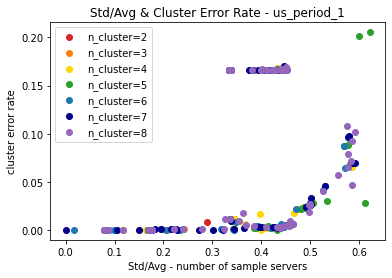

Figure 5.5: Std/Avg and Cluster Error Rate - US-1


In [29]:
# Figure 5.5: Std/Avg and Cluster Error Rate - US-1

err_up_limit = 2.5

pyplot.title(f'Std/Avg & Cluster Error Rate - {data_loc}')
pyplot.xlabel('Std/Avg - number of sample servers')
pyplot.ylabel('cluster error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    for label in range(len(mean_class_err_record[n_cluster])):
        if mean_class_err_record[n_cluster][label] > err_up_limit:
            _std_avg = std_avg_sample_num_record[n_cluster][:label] + std_avg_sample_num_record[n_cluster][label+1:]
            _class_err = mean_class_err_record[n_cluster][:label] + mean_class_err_record[n_cluster][label+1:]
            break
        else:
            _std_avg = std_avg_sample_num_record[n_cluster]
            _class_err = mean_class_err_record[n_cluster]
    pyplot.scatter(_std_avg, _class_err, color=colors[n_cluster], label=f'n_cluster={_cluster}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.5: Std/Avg and Cluster Error Rate - US-1')

In [30]:
# Table 5.5: An Example of Estimation Number = 0 - US-1

# example in Table 5.5 is 'cluster: 4' of 'n_cluster = 8, label = 5'

n_cluster = 8
label = 5
period_choose = 1

print(f'n_cluster: {n_cluster}, label: {label}')
baseline_num_class, class_ip_index = baseline_class(period_choose, n_cluster, label)
baseline_num_class = np.array(baseline_num_class)

# estimation number in class
est_p, _ = r_label_2_p2(period_choose, n_cluster, label)
sum_ch, ch_in_class = get_p1_caputure_history(period_choose, n_cluster, label)
est_p, sum_ch = np.array(est_p), np.array(sum_ch)
est_num_class = sum_ch[:, 1:] / est_p

for cluster in range(len(baseline_num_class)):
    print(f'\ncluster: {cluster}')
    print(f'baseline_num: {baseline_num_class[cluster][2:-2]}')
    print(f'estimation_num: {est_num_class[cluster][1:-2]}')
    
print('\nTable 5.5: An Example of Estimation Number = 0 - US-1')

n_cluster: 8, label: 5

cluster: 0
baseline_num: [30 31 31 31 31 31]
estimation_num: [29.99827677 30.00130291 30.0014234  31.03409965 31.00056173 31.        ]

cluster: 1
baseline_num: [52 52 52 52 52 52]
estimation_num: [52.00030227 51.9996464  51.99988863 52.0001534   0.         51.99999633]

cluster: 2
baseline_num: [38 38 38 37 37 37]
estimation_num: [38.         38.         38.         37.         37.00024235 37.        ]

cluster: 3
baseline_num: [89 89 89 89 89 89]
estimation_num: [89.29427628 89.00035416 89.0000178  89.0000089  89.00104642 89.        ]

cluster: 4
baseline_num: [67 67 67 67 67 67]
estimation_num: [67.         67.00124653 67.0000067  67.          0.         67.        ]

cluster: 5
baseline_num: [54 54 54 54 54 54]
estimation_num: [54.00054918 53.99901722 53.99980165 54.0000108   0.         54.00001969]

cluster: 6
baseline_num: [64 54 70 71 70 70]
estimation_num: [76.1832621  72.7237291  69.90395564 69.35888118 70.58668434 64.42942328]

cluster: 7
baseline_num:

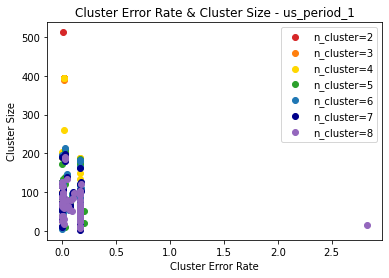

Figure 5.6: Cluster Size and Cluster Error Rate - US-1


In [31]:
# Figure 5.6: Cluster Size and Cluster Error Rate - US-1

pyplot.title(f'Cluster Error Rate & Cluster Size - {data_loc}')
pyplot.xlabel('Cluster Error Rate')
pyplot.ylabel('Cluster Size')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):  #range(6,-1,-1):
    _cluster = n_cluster+2
    pyplot.scatter(mean_class_err_record[n_cluster], cluster_size_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.6: Cluster Size and Cluster Error Rate - US-1')

period_choose: 1


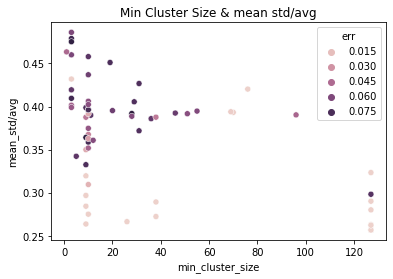

Figure 5.7: Min Cluster Size, Mean Std/Avg, and Error Rate - US-1


In [32]:
# Figure 5.7: Min Cluster Size, Mean Std/Avg, and Error Rate - US-1

# x-min size, y-std/avg, heatmap: err rate
print(f'period_choose: {period_choose}')

# for each clustering result
sns.scatterplot(data=data_df, x="min_cluster_size", y="mean_std/avg", hue="err").set(title='Min Cluster Size & mean std/avg')
pyplot.show()

print('Figure 5.7: Min Cluster Size, Mean Std/Avg, and Error Rate - US-1')

In [33]:
# Table 5.6: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-1

print('Table 5.6: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-1')

data_df.astype('float64').corr()

Table 5.6: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-1


,n_cluster,err,mean_std/avg,max_std/avg,min_cluster_size,min_cluster_err
n_cluster,1.000000,0.719256,0.855740,0.606245,-0.673990,0.357055
err,0.719256,1.000000,0.693093,0.534509,-0.524594,0.310516
mean_std/avg,0.855740,0.693093,1.000000,0.780306,-0.622249,0.374425
max_std/avg,0.606245,0.534509,0.780306,1.000000,-0.411534,0.151894
min_cluster_size,-0.673990,-0.524594,-0.622249,-0.411534,1.000000,-0.681779
min_cluster_err,0.357055,0.310516,0.374425,0.151894,-0.681779,1.000000


In [34]:
# 5.2.2 Clustering Result with US-0 - April 29 to May 05

In [35]:
# Figure 5.8: The CJS model without Clustering - US-0

# the plot is in the folder './CJS_results/us_period_0/p2_daily_plot/n_cluster_0.png'


us_period_0

n_cluster: 2
number of error rate > inf: 0
number of nan: 0

n_cluster: 3
number of error rate > inf: 0
number of nan: 1

n_cluster: 4
number of error rate > inf: 0
number of nan: 1

n_cluster: 5
number of error rate > inf: 0
number of nan: 1

n_cluster: 6
number of error rate > inf: 0
number of nan: 1

n_cluster: 7
number of error rate > inf: 0
number of nan: 2

n_cluster: 8
number of error rate > inf: 0
number of nan: 3


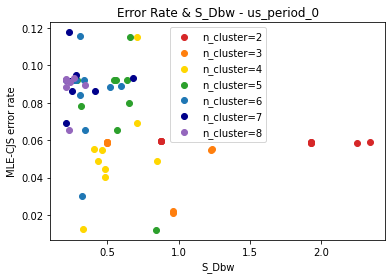

Figure 5.9: S_Dbw Score and Error Rate - US-0


In [36]:
# Figure 5.9: S_Dbw Score and Error Rate - US-0

loc_choose = 0
data_locs = ['us_period_0', 'us_period_1', 'France', 'Germany']
data_loc = data_locs[loc_choose]

print(f'\n{data_loc}')

# err > err_up_limit -> not write into record
err_up_limit = math.inf

err_record, std_record, time_record = [], [], []
km_err_record = [] # for ch 5.3 CJS with Random Clustering Results
for n_cluster in [2,3,4,5,6,7,8]:
    err_record.append([])
    std_record.append([])
    time_record.append([])
    for label in range(10):
        file_path = f'./CJS_results/{data_loc}/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record[-1].append(float(lines[-1][10:]))
        km_err_record.append(float(lines[0][5:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record[-1].append(None)
            std_record[-1].append(None)
        else:
            err_record[-1].append(float(lines[0][5:]))
            std_record[-1].append(float(lines[1][5:]))
            
        
# s_dbw_record
s_dbw_record = []
km_s_dbw_record = [] # for ch 5.3 CJS with Random Clustering Results
s_dbw_file_path = f'./CJS_results/{data_loc}/p0_cluster_result/s_dbw_record.csv'
df_sdbw = pd.read_csv(s_dbw_file_path)
df_sdbw.head()
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record.append([])
    km_s_dbw_record.append(df_sdbw['S_Dbw'][n_cluster*10+label])
    for label in range(10):
        s_dbw_record[-1].append(df_sdbw['S_Dbw'][n_cluster*10+label])

# scatter plot - Error Rate & S_Dbw
pyplot.title(f'Error Rate & S_Dbw - {data_loc}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('MLE-CJS error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    print(f'\nn_cluster: {_cluster}')
    num_over_err_up_limit = 0
    num_is_nan = 0
    for label in range(10):
        if err_record[n_cluster][label] is None:
            num_over_err_up_limit += 1
        elif np.isnan(err_record[n_cluster][label]):
            num_is_nan += 1
    print(f'number of error rate > {err_up_limit}: {num_over_err_up_limit}')
    print(f'number of nan: {num_is_nan}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.9: S_Dbw Score and Error Rate - US-0')

In [37]:
# Table 5.7: Correlation Matrix - US-0

print(f'{data_loc}\n')
data_df = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(70)))

for n_cluster in [2,3,4,5,6,7,8]:
    for label in range(10):
        index = (n_cluster-2)*10+label
        data_df['n_cluster'][index] = n_cluster
        data_df['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
        data_df['err'][index] = err_record[n_cluster-2][label]
        data_df['std'][index] = std_record[n_cluster-2][label]
        data_df['CJS_time'][index] = time_record[n_cluster-2][label]
        if err_record[n_cluster-2][label] is None:
            print(f'err is None: n_cluster={n_cluster}, label={label}')
            data_df['err'][index] = 'None'
            data_df['std'][index] = 'None'
        elif np.isnan(err_record[n_cluster-2][label]):
            print(f'err is nan: n_cluster={n_cluster}, label={label}')
            data_df['err'][index] = 'None'
            data_df['std'][index] = 'None'
            
# Delete these row indexes from dataFrame
indexNames = data_df[ data_df['err'] == 'None' ].index
print(f'drop index: {indexNames}')
data_df.drop(indexNames , inplace=True)
km_data_df_us_0 = data_df # for ch5.3

data_df.head(20)
max_time = max(data_df['CJS_time'])
print(f'max CJS time: {max_time}')
print('\nTable 5.7: Correlation Matrix - US-0')

data_df.astype('float64').corr()

us_period_0

err is nan: n_cluster=3, label=2
err is nan: n_cluster=4, label=6
err is nan: n_cluster=5, label=6
err is nan: n_cluster=6, label=0
err is nan: n_cluster=7, label=2
err is nan: n_cluster=7, label=7
err is nan: n_cluster=8, label=3
err is nan: n_cluster=8, label=7
err is nan: n_cluster=8, label=9
drop index: Int64Index([12, 26, 36, 40, 52, 57, 63, 67, 69], dtype='int64')
max CJS time: 4.235488

Table 5.7: Correlation Matrix - US-0


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.716253,0.571198,0.755107,0.975549
S_Dbw,-0.716253,1.000000,-0.346569,-0.520805,-0.644142
err,0.571198,-0.346569,1.000000,0.812678,0.536164
std,0.755107,-0.520805,0.812678,1.000000,0.686986
CJS_time,0.975549,-0.644142,0.536164,0.686986,1.000000


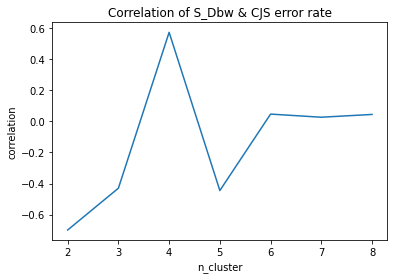

Figure 5.10: The Correlation of S_Dbw and Error Rate - US-0


In [38]:
# Figure 5.10: The Correlation of S_Dbw and Error Rate - US-0

correlation_sdbw_err, n_clusters = [], []
for n_cluster in range(7):
    n_clusters.append(n_cluster+2)
    corr = data_df[ data_df['n_cluster'] == n_cluster+2 ].astype('float64').corr()['S_Dbw']['err']
    correlation_sdbw_err.append(corr)

n_clusters = [2,3,4,5,6,7,8]
pyplot.title('Correlation of S_Dbw & CJS error rate')
pyplot.xlabel('n_cluster')
pyplot.ylabel('correlation')
pyplot.plot(n_clusters, correlation_sdbw_err)
pyplot.show()

print('Figure 5.10: The Correlation of S_Dbw and Error Rate - US-0')

In [39]:
# n_cluster, cluster_err, std/avg, cluster_size

n_clusters = [2,3,4,5,6,7,8]
period_choose = 0

# dataFrame for each cluster (class)
data_cluster_df = pd.DataFrame(columns = ['n_cluster', 'cluster_err', 'std/avg', 'cluster_size'], index=list(range(10*(np.sum(n_clusters)))))

# dataFrame for each clustering result
data_df = pd.DataFrame(columns = ['n_cluster', 'err', 'mean_std/avg', 'max_std/avg', 'min_cluster_size', 'min_cluster_err'], index=list(range(70)))

if period_choose == 0:
    ip_trans_count_dict = ip_trans_count_dict_p0
    baseline_ip_sum = baseline_ip_sum_p0
    s_dbw_record = s_dbw_record_p0
elif period_choose == 1:
    ip_trans_count_dict = ip_trans_count_dict_p1
    baseline_ip_sum = baseline_ip_sum_p1
    s_dbw_record = s_dbw_record_p1

# min_class_size for each clustering result
min_class_size = []
err_record = []
min_cluster_bias_proportion = [] # np.mean(bias_class[min_cluster_index]/est_sum[min_cluster_index])
min_cluster_err = []

# err & std/avg for each clusters
mean_class_err_record = []
std_avg_sample_num_record = []
cluster_size_record = []
index = 0 # for dataFrame
for n_cluster in n_clusters:
    mean_class_err_record.append([])
    std_avg_sample_num_record.append([])
    cluster_size_record.append([])
    for label in range(10):
        baseline_num_class, class_ip_index = baseline_class(period_choose, n_cluster, label)
        baseline_num_class = np.array(baseline_num_class)
        
        # estimation number in class
        est_p, _ = r_label_2_p2(period_choose, n_cluster, label)
        sum_ch, ch_in_class = get_p1_caputure_history(period_choose, n_cluster, label)
        est_p, sum_ch = np.array(est_p), np.array(sum_ch)
        est_num_class = sum_ch[:, 1:] / est_p
        err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
        
        # total est number
        est_sum = np.sum(est_num_class, axis=0)
        class_sizes = []
        for _class in range(n_cluster):
            class_sizes.append(len(class_ip_index[_class]))
            mean_class_err_record[-1].append(np.mean(err_class[_class]))
            std_avg_sample_num_record[-1].append(np.std(sum_ch[_class])/np.mean(sum_ch[_class]))
            cluster_size_record[-1].append(len(class_ip_index[_class]))
            
            # dataFrame
            data_cluster_df['n_cluster'][index] = n_cluster
            data_cluster_df['cluster_err'][index] = mean_class_err_record[-1][-1]
            data_cluster_df['std/avg'][index] = std_avg_sample_num_record[-1][-1]
            data_cluster_df['cluster_size'][index] = len(class_ip_index[_class])
            index += 1
        min_class_size.append(min(class_sizes))
        err_record.append(np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2]))
        # bias in min cluster
        min_cluster_index = class_sizes.index(min(class_sizes))
        bias_class = np.abs(est_num_class[:,1:-2] - baseline_num_class[:,2:-2])
        nan_in_bias_class = False
        for bias in bias_class[min_cluster_index]:
            if np.isnan(bias):
                nan_in_bias_class = True
        if not nan_in_bias_class:
            min_cluster_bias_proportion.append(np.mean(bias_class[min_cluster_index]/est_sum[1:-2]))
            min_cluster_err.append(np.mean(err_class[min_cluster_index]))
        data_df_index = (n_cluster-2)*10 + label
        data_df['n_cluster'][data_df_index] = n_cluster
        data_df['err'][data_df_index] = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
        data_df['mean_std/avg'][data_df_index] = np.mean(std_avg_sample_num_record[-1])
        data_df['max_std/avg'][data_df_index] = max(std_avg_sample_num_record[-1])
        data_df['min_cluster_size'][data_df_index] = min(class_sizes)
        data_df['min_cluster_err'][data_df_index] = np.mean(err_class[min_cluster_index])
        
# Delete these row indexes from dataFrame
indexNames = data_cluster_df[ data_cluster_df['cluster_err'] == 'None' ].index
print(f'drop index: {indexNames}')
data_cluster_df.drop(indexNames , inplace=True)

# correlation matrix
print(f'\nperiod_choose: {period_choose}')
data_cluster_df.astype('float64').corr()

C:\Users\smart\AppData\Local\Temp\ipykernel_5828\2461144878.py:44: RuntimeWarning: divide by zero encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p
C:\Users\smart\AppData\Local\Temp\ipykernel_5828\2461144878.py:44: RuntimeWarning: invalid value encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p
C:\Users\smart\AppData\Local\Temp\ipykernel_5828\2461144878.py:45: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]


drop index: Int64Index([], dtype='int64')

period_choose: 0


,n_cluster,cluster_err,std/avg,cluster_size
n_cluster,1.000000,0.149365,0.155766,-0.433762
cluster_err,0.149365,1.000000,0.934658,-0.143050
std/avg,0.155766,0.934658,1.000000,-0.160073
cluster_size,-0.433762,-0.143050,-0.160073,1.000000


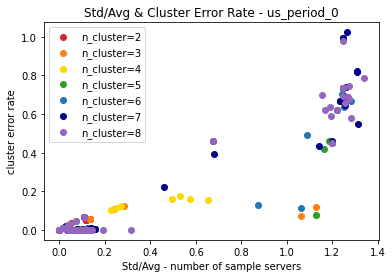

Figure 5.11: Std/Avg and Cluster Error Rate - US-0


In [40]:
# Figure 5.11: Std/Avg and Cluster Error Rate - US-0

err_up_limit = math.inf

pyplot.title(f'Std/Avg & Cluster Error Rate - {data_loc}')
pyplot.xlabel('Std/Avg - number of sample servers')
pyplot.ylabel('cluster error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    for label in range(len(mean_class_err_record[n_cluster])):
        if mean_class_err_record[n_cluster][label] > err_up_limit:
            _std_avg = std_avg_sample_num_record[n_cluster][:label] + std_avg_sample_num_record[n_cluster][label+1:]
            _class_err = mean_class_err_record[n_cluster][:label] + mean_class_err_record[n_cluster][label+1:]
            break
        else:
            _std_avg = std_avg_sample_num_record[n_cluster]
            _class_err = mean_class_err_record[n_cluster]
    pyplot.scatter(_std_avg, _class_err, color=colors[n_cluster], label=f'n_cluster={_cluster}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.11: Std/Avg and Cluster Error Rate - US-0')

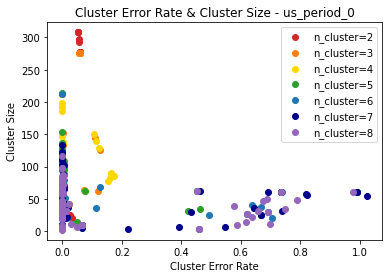

Figure 5.12: Cluster Size and Cluster Error Rate - US-0


In [41]:
# Figure 5.12: Cluster Size and Cluster Error Rate - US-0

pyplot.title(f'Cluster Error Rate & Cluster Size - {data_loc}')
pyplot.xlabel('Cluster Error Rate')
pyplot.ylabel('Cluster Size')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):  #range(6,-1,-1):
    _cluster = n_cluster+2
    pyplot.scatter(mean_class_err_record[n_cluster], cluster_size_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    
pyplot.legend()
pyplot.show()

print('Figure 5.12: Cluster Size and Cluster Error Rate - US-0')

period_choose: 0


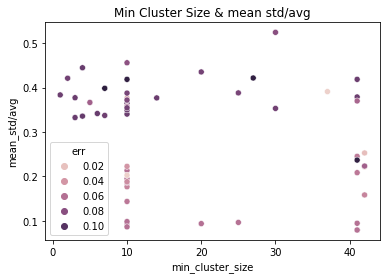

Figure 5.13: Min Cluster Size, Mean Std/Avg, and Error Rate - US-0


In [42]:
# Figure 5.13: Min Cluster Size, Mean Std/Avg, and Error Rate - US-0

# x-min size, y-std/avg, heatmap: err rate
print(f'period_choose: {period_choose}')

# for each clustering result
sns.scatterplot(data=data_df, x="min_cluster_size", y="mean_std/avg", hue="err").set(title='Min Cluster Size & mean std/avg')
pyplot.show()

print('Figure 5.13: Min Cluster Size, Mean Std/Avg, and Error Rate - US-0')

In [43]:
# Table 5.8: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-0

print('Table 5.8: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-0')

data_df.astype('float64').corr()

Table 5.8: Correlation Matrix of Min Cluster Size and Mean Std/Avg - US-0


,n_cluster,err,mean_std/avg,max_std/avg,min_cluster_size,min_cluster_err
n_cluster,1.000000,0.571198,0.793945,0.766511,-0.479314,0.358768
err,0.571198,1.000000,0.547187,0.395443,-0.253152,0.332748
mean_std/avg,0.793945,0.547187,1.000000,0.828422,-0.271166,0.414870
max_std/avg,0.766511,0.395443,0.828422,1.000000,-0.291352,0.285818
min_cluster_size,-0.479314,-0.253152,-0.271166,-0.291352,1.000000,-0.124866
min_cluster_err,0.358768,0.332748,0.414870,0.285818,-0.124866,1.000000


In [44]:
# Ch 5.3 CJS with Random Clustering Results

In [45]:
# caculate baseline in clusters
def baseline_class_random(data_period, n_cluster, label):
    id_index_path = f'./CJS_results/{data_period}/random_nc_2to8/p1_capture_history/ip_index.txt'
    with open(id_index_path) as f:
        ip_index = f.readlines()
    group_path = f'./CJS_results/{data_period}/random_nc_2to8/p1_capture_history/n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
        
    if int(data_period[-1]) == 0:
        ip_date_dict = ip_date_dict_p0
    elif int(data_period[-1]) == 1:
        ip_date_dict = ip_date_dict_p1
    baseline_ip_num_class = []
    for date in sorted(ip_date_dict):
        #print(date)
        baseline_ip_num_class.append([]) # new date
        for i in range(n_cluster):
            baseline_ip_num_class[-1].append(0) # each class number
        for i in range(len(ip_index)):
            ip = ip_index[i][:-1] # last two is '\n'
            group = int(groups[i][5]) # class0, class1, ...
            if ip in ip_date_dict[date]:
                baseline_ip_num_class[-1][group] += 1
    
    out_baseline_ip_num_class = []
    for _class in range(n_cluster):
        out_baseline_ip_num_class.append([])
        for date in range(len(baseline_ip_num_class)):
            out_baseline_ip_num_class[-1].append(baseline_ip_num_class[date][_class])
            
    # ip index for each class
    baseline_ip_index_class = []
    for i in range(n_cluster):
        baseline_ip_index_class.append([]) # each class
    for i in range(len(ip_index)):
        ip = ip_index[i][:-1] # last two is '\n'
        group = int(groups[i][5]) # class0, class1, ...
        baseline_ip_index_class[group].append(ip)
    return out_baseline_ip_num_class, baseline_ip_index_class


In [46]:
# Get the capture_p from R
def r_label_2_p2_random(data_period, n_cluster, label):
    file_path = f'./CJS_results/{data_period}/random_nc_2to8/R_capture_probability/n_cluster_{n_cluster}/r_{label}.txt'
    with open(file_path) as f:
        lines = f.readlines()
    # locate the p
    start=100000
    end=0
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for i in range(len(lines)):
        if lines[i][:2] == '$p':
            start=i+1
        elif lines[i] == lines[-3]:
            end=i
    CJS_time_use = float(lines[-1][19:-6])
    # record class, time, est
    class_loc, time_loc = 0,0 # new: for locate where the class and time in one line
    for i in range(len(lines[start])):
        if lines[start][i]=='c': # cluster
            if lines[start][i+1]=='l' and lines[start][i+6]=='r':
                class_loc=i+6
        elif lines[start][i]=='t': # time
            if lines[start][i+1]=='i': # avoid 'estimate'
                if lines[start][i+3]=='e':
                    time_loc=i+3
    class_record = []
    time_record = []
    est_record = [] # ex: 6.197041e-01
    for line in lines[start+1:-2]:
        class_record.append(int(line[class_loc]))
        if line[time_loc-1] in numbers:
            time_record.append(int(line[time_loc-1:time_loc+1]))
        else:
            time_record.append(int(line[time_loc]))
        est_record.append(float(line[time_loc+6:-1]))
    
    clusters = np.unique(class_record)
    num_cluster = len(clusters)
    time_len = len(dates[int(data_period[-1])])-1 # time = 2 ~ last date 
    est_p_sort = [] # [[], []] num of class = num of list()
    for i in range(num_cluster):
        est_p_sort.append([])
        for j in range(time_len):
            est_p_sort[-1].append(0) # est num will be 'INF' if append '0' and some data not load 
    for i in range(len(time_record)):
        est_p_sort[class_record[i]][time_record[i]-2] = est_record[i]
    return est_p_sort, CJS_time_use


In [47]:
# Get the capture_p from R
def r_label_2_p2_random(data_period, n_cluster, label):
    file_path = f'./CJS_results/{data_period}/random_nc_2to8/R_capture_probability/n_cluster_{n_cluster}/r_{label}.txt'
    with open(file_path) as f:
        lines = f.readlines()
    # locate the p
    start=100000
    end=0
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for i in range(len(lines)):
        if lines[i][:2] == '$p':
            start=i+1
        elif lines[i] == lines[-3]:
            end=i
    CJS_time_use = float(lines[-1][19:-6])
    # record class, time, est
    class_loc, time_loc = 0,0 # new: for locate where the class and time in one line
    for i in range(len(lines[start])):
        if lines[start][i]=='c': # cluster
            if lines[start][i+1]=='l' and lines[start][i+6]=='r':
                class_loc=i+6
        elif lines[start][i]=='t': # time
            if lines[start][i+1]=='i': # avoid 'estimate'
                if lines[start][i+3]=='e':
                    time_loc=i+3
    class_record = []
    time_record = []
    est_record = [] # ex: 6.197041e-01
    for line in lines[start+1:-2]:
        class_record.append(int(line[class_loc]))
        if line[time_loc-1] in numbers:
            time_record.append(int(line[time_loc-1:time_loc+1]))
        else:
            time_record.append(int(line[time_loc]))
        est_record.append(float(line[time_loc+6:-1]))
    
    clusters = np.unique(class_record)
    num_cluster = len(clusters)
    time_len = len(dates[int(data_period[-1])])-1 # time = 2 ~ last date
    est_p_sort = [] # [[], []] num of class = num of list()
    for i in range(num_cluster):
        est_p_sort.append([])
        for j in range(time_len):
            est_p_sort[-1].append(0) # est num will be 'INF' if append '0' and some data not load 
    for i in range(len(time_record)):
        est_p_sort[class_record[i]][time_record[i]-2] = est_record[i]
    return est_p_sort, CJS_time_use

In [48]:
# Get the capture history from p1
def get_p1_caputure_history_random(data_period, n_cluster, label):
    label_path = f'./CJS_results/{data_period}/random_nc_2to8/p1_capture_history/n_cluster_{n_cluster}/label_{label}.txt'
    with open(label_path) as f:
        chs = f.readlines()
    group_path = f'./CJS_results/{data_period}/random_nc_2to8/p1_capture_history/n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
    ch_in_class = [] # [[capture_history in class-0], [capture_history in class-1], ...]
    for i in range(n_cluster):
        ch_in_class.append([])
    for i in range(len(chs)):
        group = int(groups[i][5])
        ch_in_class[group].append(chs[i][:-1]) # last 2 is \n
        
    sum_ch_in_class = [] # [[sample number in class-0], [sample number in class-1], ...]
    for _class in range(len(ch_in_class)): # class
        sum_class = []
        for date in range(len(dates[int(data_period[-1])])):
            sum_class.append(0)
            for j in range(len(ch_in_class[_class])): # servers in a class
                sum_class[date] += int(ch_in_class[_class][j][date])
        sum_ch_in_class.append(sum_class)
    return sum_ch_in_class, ch_in_class

In [49]:
# Ch 5.3.1 Random Clustering Results in US-0

data_period = 'us_period_0'

In [50]:
# err_record, std_record, time_record, s_dbw_record

print(f'data: {data_period}')
label_number_each_n_cluster = 20

# err > err_up_limit -> not write into record
err_up_limit = math.inf #10**2
print(f'err_up_limit: {err_up_limit}')
    
# error rate - clustering result
period_choose = 0
err_record_p0, std_record_p0, time_record_p0 = [], [], []
for n_cluster in [2,3,4,5,6,7,8]:
    err_record_p0.append([])
    std_record_p0.append([])
    time_record_p0.append([])
    for label in range(label_number_each_n_cluster):
        file_path = f'./CJS_results/us_period_0/random_nc_2to8/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record_p0[-1].append(float(lines[-1][10:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record_p0[-1].append(None)
            std_record_p0[-1].append(None)
        else:
            err_record_p0[-1].append(float(lines[0][5:]))
            std_record_p0[-1].append(float(lines[1][5:]))
            
period_choose = 1
err_record_p1, std_record_p1, time_record_p1 = [], [], []
for n_cluster in [2,3,4,5,6,7,8]:
    err_record_p1.append([])
    std_record_p1.append([])
    time_record_p1.append([])
    for label in range(label_number_each_n_cluster):
        file_path = f'./CJS_results/us_period_1/random_nc_2to8/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record_p1[-1].append(float(lines[-1][10:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record_p1[-1].append(None)
            std_record_p1[-1].append(None)
        else:
            err_record_p1[-1].append(float(lines[0][5:]))
            std_record_p1[-1].append(float(lines[1][5:]))
        
print('finish err_record, std_record, time_record')

# s_dbw_record
period_choose = 0
s_dbw_record_p0 = []
s_dbw_file_path = f'./CJS_results/us_period_0/random_nc_2to8/p0_cluster_result/s_dbw_record.csv'
df_sdbw_p0 = pd.read_csv(s_dbw_file_path)
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record_p0.append([])
    for label in range(label_number_each_n_cluster):
        s_dbw_record_p0[-1].append(df_sdbw_p0['S_Dbw'][n_cluster*label_number_each_n_cluster+label])
        
period_choose = 1
s_dbw_record_p1 = []
s_dbw_file_path = f'./CJS_results/us_period_1/random_nc_2to8/p0_cluster_result/s_dbw_record.csv'
df_sdbw_p1 = pd.read_csv(s_dbw_file_path)
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record_p1.append([])
    for label in range(label_number_each_n_cluster):
        s_dbw_record_p1[-1].append(df_sdbw_p1['S_Dbw'][n_cluster*label_number_each_n_cluster+label])
        
print('finish s_dbw_record')

data: us_period_0
err_up_limit: inf
finish err_record, std_record, time_record
finish s_dbw_record


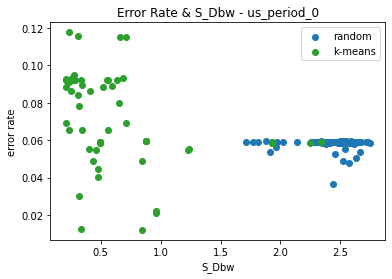

Figure 5.14: K-Means Results and Random Clustering Results - US-0


In [51]:
# Figure 5.14: K-Means Results and Random Clustering Results - US-0

pyplot.title(f'Error Rate & S_Dbw - {data_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(s_dbw_record_p0, err_record_p0, color='tab:blue', label='random')
pyplot.scatter(km_data_df_us_0['S_Dbw'], km_data_df_us_0['err'], color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 5.14: K-Means Results and Random Clustering Results - US-0')

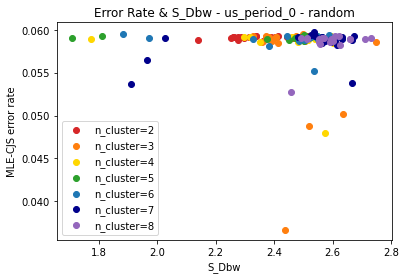

Figure 5.15: Error Rate and S_Dbw of Random Clustering Results - US-0


In [52]:
# Figure 5.15: Error Rate and S_Dbw of Random Clustering Results - US-0

random_period_choose = 0
data_period = 'us_period_0'

if random_period_choose == 0:
    err_record, std_record, time_record = err_record_p0, std_record_p0, time_record_p0
    s_dbw_record = s_dbw_record_p0
elif random_period_choose == 1:
    err_record, std_record, time_record = err_record_p1, std_record_p1, time_record_p1
    s_dbw_record = s_dbw_record_p1
    
# plot
pyplot.title(f'Error Rate & S_Dbw - {data_period} - random')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('MLE-CJS error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    num_over_err_up_limit = 0
    num_is_nan = 0
    for label in range(label_number_each_n_cluster):
        if err_record[n_cluster][label] is None:
            num_over_err_up_limit += 1
        elif np.isnan(err_record[n_cluster][label]):
            num_is_nan += 1
    
pyplot.legend()
pyplot.show()

print('Figure 5.15: Error Rate and S_Dbw of Random Clustering Results - US-0')

In [53]:
# Table 5.9: Correlation Matrix - Random Clustering in US-0

print(f'{data_period}')
print(f'err_up_limit: {err_up_limit}')

random_data_df_from_p2 = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(7*label_number_each_n_cluster)))

for n_cluster in [2,3,4,5,6,7,8]:
    for label in range(label_number_each_n_cluster):
        index = (n_cluster-2)*label_number_each_n_cluster+label
        random_data_df_from_p2['n_cluster'][index] = n_cluster
        random_data_df_from_p2['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
        random_data_df_from_p2['err'][index] = err_record[n_cluster-2][label]
        random_data_df_from_p2['std'][index] = std_record[n_cluster-2][label]
        random_data_df_from_p2['CJS_time'][index] = time_record[n_cluster-2][label]
        if err_record[n_cluster-2][label] is None:
            print(f'err is None: n_cluster={n_cluster}, label={label}')
            random_data_df_from_p2['err'][index] = 'None'
            random_data_df_from_p2['std'][index] = 'None'
        elif np.isnan(err_record[n_cluster-2][label]):
            print(f'err is nan: n_cluster={n_cluster}, label={label}')
            random_data_df_from_p2['err'][index] = 'None'
            random_data_df_from_p2['std'][index] = 'None'
            
# Delete these row indexes from dataFrame
indexNames = random_data_df_from_p2[ random_data_df_from_p2['err'] == 'None' ].index
print(f'drop index: {indexNames}')
random_data_df_from_p2.drop(indexNames , inplace=True)

print()
mean_err = np.mean(random_data_df_from_p2['err'])
print(f'mean err: {mean_err}')
max_time = max(random_data_df_from_p2['CJS_time'])
print(f'max CJS time: {max_time}')

print('\nTable 5.9: Correlation Matrix - Random Clustering in US-0')
random_data_df_from_p2.astype('float64').corr()

us_period_0
err_up_limit: inf
drop index: Int64Index([], dtype='int64')

mean err: 0.05847282554745881
max CJS time: 7.275306

Table 5.9: Correlation Matrix - Random Clustering in US-0


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,0.327498,0.041745,0.001498,0.938558
S_Dbw,0.327498,1.000000,-0.016804,-0.033785,0.322720
err,0.041745,-0.016804,1.000000,-0.796404,0.007303
std,0.001498,-0.033785,-0.796404,1.000000,0.056957
CJS_time,0.938558,0.322720,0.007303,0.056957,1.000000


cluster_err_up_limit: inf
n_cluster: 2
err_num_class: 40
n_cluster: 3
err_num_class: 60
n_cluster: 4
err_num_class: 80
n_cluster: 5
err_num_class: 100
n_cluster: 6
err_num_class: 120
n_cluster: 7
err_num_class: 140
n_cluster: 8
err_num_class: 160


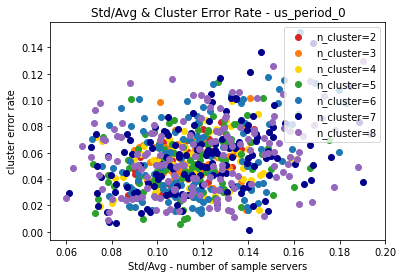

Figure 5.16: Cluster Error Rate and Std/Avg of Random Clustering Results - US-0


,n_cluster,err,mean_std/avg,max_std/avg,min_cluster_size,min_cluster_err
n_cluster,1.000000,0.041745,0.935072,0.865860,-0.923137,0.024648
err,0.041745,1.000000,0.085817,0.077869,-0.012240,0.116775
mean_std/avg,0.935072,0.085817,1.000000,0.923046,-0.844651,0.058104
max_std/avg,0.865860,0.077869,0.923046,1.000000,-0.814474,0.040289
min_cluster_size,-0.923137,-0.012240,-0.844651,-0.814474,1.000000,-0.062705
min_cluster_err,0.024648,0.116775,0.058104,0.040289,-0.062705,1.000000


In [54]:
# Figure 5.16: Cluster Error Rate and Std/Avg of Random Clustering Results - US-0

n_clusters = [2,3,4,5,6,7,8]
label_number_each_n_cluster = 20
cluster_err_up_limit = math.inf
print(f'cluster_err_up_limit: {cluster_err_up_limit}')

# dataFrame for each cluster (class)
data_cluster_df = pd.DataFrame(columns = ['n_cluster', 'cluster_err', 'std/avg', 'cluster_size'], index=list(range(label_number_each_n_cluster*(np.sum(n_clusters)))))

# dataFrame for each clustering result
data_df = pd.DataFrame(columns = ['n_cluster', 'err', 'mean_std/avg', 'max_std/avg', 'min_cluster_size', 'min_cluster_err'], index=list(range(7*label_number_each_n_cluster)))

if random_period_choose == 0:
    baseline_ip_sum = baseline_ip_sum_p0
    s_dbw_record = s_dbw_record_p0
elif random_period_choose == 1:
    baseline_ip_sum = baseline_ip_sum_p1
    s_dbw_record = s_dbw_record_p1

# min_class_size for each clustering result
min_class_size = []
err_record = []
min_cluster_bias_proportion = [] # np.mean(bias_class[min_cluster_index]/est_sum[min_cluster_index])
min_cluster_err = []

# err & std/avg for each clusters
mean_class_err_record = []
std_avg_sample_num_record = []
cluster_size_record = []
index = 0 # for dataFrame
for n_cluster in n_clusters:
    mean_class_err_record.append([])
    std_avg_sample_num_record.append([])
    cluster_size_record.append([])
    for label in range(label_number_each_n_cluster):
        # baseline number in class
        baseline_num_class, class_ip_index = baseline_class_random(data_period, n_cluster, label)
        baseline_num_class = np.array(baseline_num_class)
        
        # estimation number in class
        est_p, _ = r_label_2_p2_random(data_period, n_cluster, label)
        sum_ch, ch_in_class = get_p1_caputure_history_random(data_period, n_cluster, label)
        est_p, sum_ch = np.array(est_p), np.array(sum_ch)
        est_num_class = sum_ch[:, 1:] / est_p
        err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
        
        # total est number
        est_sum = np.sum(est_num_class, axis=0)
        class_sizes = []
        for _class in range(n_cluster):
            class_sizes.append(len(class_ip_index[_class]))
            if np.mean(err_class[_class]) > cluster_err_up_limit:
                continue
            mean_class_err_record[-1].append(np.mean(err_class[_class]))
            std_avg_sample_num_record[-1].append(np.std(sum_ch[_class])/np.mean(sum_ch[_class]))
            cluster_size_record[-1].append(len(class_ip_index[_class]))
            
            # dataFrame
            data_cluster_df['n_cluster'][index] = n_cluster
            data_cluster_df['cluster_err'][index] = mean_class_err_record[-1][-1]
            data_cluster_df['std/avg'][index] = std_avg_sample_num_record[-1][-1]
            data_cluster_df['cluster_size'][index] = len(class_ip_index[_class])
            index += 1
        min_class_size.append(min(class_sizes))
        err_record.append(np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2]))
        # bias in min cluster
        min_cluster_index = class_sizes.index(min(class_sizes))
        bias_class = np.abs(est_num_class[:,1:-2] - baseline_num_class[:,2:-2])
        nan_in_bias_class = False
        for bias in bias_class[min_cluster_index]:
            if np.isnan(bias):
                nan_in_bias_class = True
        if not nan_in_bias_class:
            min_cluster_bias_proportion.append(np.mean(bias_class[min_cluster_index]/est_sum[1:-2]))
            min_cluster_err.append(np.mean(err_class[min_cluster_index]))
        data_df_index = (n_cluster-2)*label_number_each_n_cluster + label
        data_df['n_cluster'][data_df_index] = n_cluster
        data_df['err'][data_df_index] = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
        data_df['mean_std/avg'][data_df_index] = np.mean(std_avg_sample_num_record[-1])
        data_df['max_std/avg'][data_df_index] = max(std_avg_sample_num_record[-1])
        data_df['min_cluster_size'][data_df_index] = min(class_sizes)
        data_df['min_cluster_err'][data_df_index] = np.mean(err_class[min_cluster_index])

# scatter plot - sample num std & err mean
pyplot.title(f'Std/Avg & Cluster Error Rate - {data_period}')
pyplot.xlabel('Std/Avg - number of sample servers')
pyplot.ylabel('cluster error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

err_sum=0
err_num=0
for n_cluster in range(7):
    _cluster = n_cluster+2
    print(f'n_cluster: {_cluster}')
    pyplot.scatter(std_avg_sample_num_record[n_cluster], mean_class_err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    err_num_class = 0
    for err_i in range(len(mean_class_err_record[n_cluster])):
        err = mean_class_err_record[n_cluster][err_i]
        if np.isnan(err):
            print(f'err is nan: {err_i}')
            continue
        err_sum += err
        err_num += 1
        err_num_class += 1
    print(f'err_num_class: {err_num_class}')
    
    
pyplot.legend()
pyplot.show()

print('Figure 5.16: Cluster Error Rate and Std/Avg of Random Clustering Results - US-0')
data_df.astype('float64').corr()

In [55]:
# Ch 5.2.2 Clustering Result with US-0 - April 29 to May 05

data_period = 'us_period_1'

In [56]:
# err_record, std_record, time_record, s_dbw_record

print(f'data: {data_period}')
label_number_each_n_cluster = 20

# err > err_up_limit -> not write into record
err_up_limit = math.inf #10**2
print(f'err_up_limit: {err_up_limit}')
    
# error rate - clustering result
period_choose = 0
err_record_p0, std_record_p0, time_record_p0 = [], [], []
for n_cluster in [2,3,4,5,6,7,8]:
    err_record_p0.append([])
    std_record_p0.append([])
    time_record_p0.append([])
    for label in range(label_number_each_n_cluster):
        file_path = f'./CJS_results/us_period_0/random_nc_2to8/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record_p0[-1].append(float(lines[-1][10:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record_p0[-1].append(None)
            std_record_p0[-1].append(None)
        else:
            err_record_p0[-1].append(float(lines[0][5:]))
            std_record_p0[-1].append(float(lines[1][5:]))
            
period_choose = 1
err_record_p1, std_record_p1, time_record_p1 = [], [], []
for n_cluster in [2,3,4,5,6,7,8]:
    err_record_p1.append([])
    std_record_p1.append([])
    time_record_p1.append([])
    for label in range(label_number_each_n_cluster):
        file_path = f'./CJS_results/us_period_1/random_nc_2to8/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
        with open(file_path) as f:
            lines = f.readlines()
        time_record_p1[-1].append(float(lines[-1][10:]))
        if float(lines[0][5:]) > err_up_limit:
            err_record_p1[-1].append(None)
            std_record_p1[-1].append(None)
        else:
            err_record_p1[-1].append(float(lines[0][5:]))
            std_record_p1[-1].append(float(lines[1][5:]))
        
print('finish err_record, std_record, time_record')

# s_dbw_record
period_choose = 0
s_dbw_record_p0 = []
s_dbw_file_path = f'./CJS_results/us_period_0/random_nc_2to8/p0_cluster_result/s_dbw_record.csv'
df_sdbw_p0 = pd.read_csv(s_dbw_file_path)
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record_p0.append([])
    for label in range(label_number_each_n_cluster):
        s_dbw_record_p0[-1].append(df_sdbw_p0['S_Dbw'][n_cluster*label_number_each_n_cluster+label])
        
period_choose = 1
s_dbw_record_p1 = []
s_dbw_file_path = f'./CJS_results/us_period_1/random_nc_2to8/p0_cluster_result/s_dbw_record.csv'
df_sdbw_p1 = pd.read_csv(s_dbw_file_path)
for n_cluster in range(7): # n_cluster=2~8
    s_dbw_record_p1.append([])
    for label in range(label_number_each_n_cluster):
        s_dbw_record_p1[-1].append(df_sdbw_p1['S_Dbw'][n_cluster*label_number_each_n_cluster+label])
        
print('finish s_dbw_record')

data: us_period_1
err_up_limit: inf
finish err_record, std_record, time_record
finish s_dbw_record


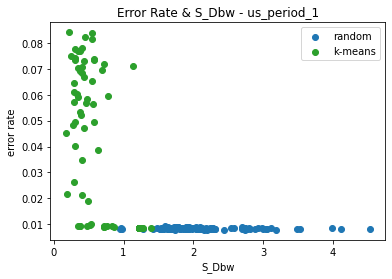

Figure 5.14: K-Means Results and Random Clustering Results - US-0


In [57]:
# Figure 5.14: K-Means Results and Random Clustering Results - US-0

pyplot.title(f'Error Rate & S_Dbw - {data_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(s_dbw_record_p1, err_record_p1, color='tab:blue', label='random')
pyplot.scatter(km_data_df_us_1['S_Dbw'], km_data_df_us_1['err'], color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 5.14: K-Means Results and Random Clustering Results - US-0')

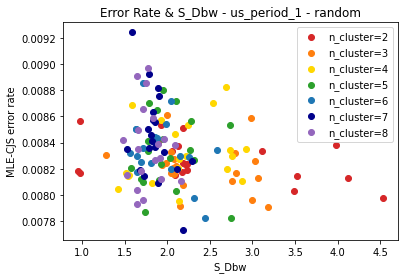

Figure 5.18: Error Rate and S_Dbw of Random Clustering Results - US-1


In [58]:
# Figure 5.18: Error Rate and S_Dbw of Random Clustering Results - US-1

random_period_choose = 1

if random_period_choose == 0:
    err_record, std_record, time_record = err_record_p0, std_record_p0, time_record_p0
    s_dbw_record = s_dbw_record_p0
elif random_period_choose == 1:
    err_record, std_record, time_record = err_record_p1, std_record_p1, time_record_p1
    s_dbw_record = s_dbw_record_p1
    
# plot
pyplot.title(f'Error Rate & S_Dbw - {data_period} - random')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('MLE-CJS error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

for n_cluster in range(7):
    _cluster = n_cluster+2
    pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    num_over_err_up_limit = 0
    num_is_nan = 0
    for label in range(label_number_each_n_cluster):
        if err_record[n_cluster][label] is None:
            num_over_err_up_limit += 1
        elif np.isnan(err_record[n_cluster][label]):
            num_is_nan += 1
    
pyplot.legend()
pyplot.show()

print('Figure 5.18: Error Rate and S_Dbw of Random Clustering Results - US-1')

In [59]:
# Table 5.10: Correlation Matrix - Random Clustering in US-1

print(f'{data_period}')
print(f'err_up_limit: {err_up_limit}')

random_data_df_from_p2 = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(7*label_number_each_n_cluster)))

for n_cluster in [2,3,4,5,6,7,8]:
    for label in range(label_number_each_n_cluster):
        index = (n_cluster-2)*label_number_each_n_cluster+label
        random_data_df_from_p2['n_cluster'][index] = n_cluster
        random_data_df_from_p2['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
        random_data_df_from_p2['err'][index] = err_record[n_cluster-2][label]
        random_data_df_from_p2['std'][index] = std_record[n_cluster-2][label]
        random_data_df_from_p2['CJS_time'][index] = time_record[n_cluster-2][label]
        if err_record[n_cluster-2][label] is None:
            print(f'err is None: n_cluster={n_cluster}, label={label}')
            random_data_df_from_p2['err'][index] = 'None'
            random_data_df_from_p2['std'][index] = 'None'
        elif np.isnan(err_record[n_cluster-2][label]):
            print(f'err is nan: n_cluster={n_cluster}, label={label}')
            random_data_df_from_p2['err'][index] = 'None'
            random_data_df_from_p2['std'][index] = 'None'
            
# Delete these row indexes from dataFrame
indexNames = random_data_df_from_p2[ random_data_df_from_p2['err'] == 'None' ].index
print(f'drop index: {indexNames}')
random_data_df_from_p2.drop(indexNames , inplace=True)

print()
mean_err = np.mean(random_data_df_from_p2['err'])
print(f'mean err: {mean_err}')
max_time = max(random_data_df_from_p2['CJS_time'])
print(f'max CJS time: {max_time}')

print('\nTable 5.10: Correlation Matrix - Random Clustering in US-1')
random_data_df_from_p2.astype('float64').corr()

us_period_1
err_up_limit: inf
drop index: Int64Index([], dtype='int64')

mean err: 0.008327578899184403
max CJS time: 21.77228

Table 5.10: Correlation Matrix - Random Clustering in US-1


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.427288,0.232267,0.210624,0.972148
S_Dbw,-0.427288,1.000000,-0.221243,0.003562,-0.401282
err,0.232267,-0.221243,1.000000,-0.486901,0.215229
std,0.210624,0.003562,-0.486901,1.000000,0.241372
CJS_time,0.972148,-0.401282,0.215229,0.241372,1.000000


cluster_err_up_limit: inf
n_cluster: 2
err_num_class: 40
n_cluster: 3
err_num_class: 60
n_cluster: 4
err_num_class: 80
n_cluster: 5
err_num_class: 100
n_cluster: 6
err_num_class: 120
n_cluster: 7
err_num_class: 140
n_cluster: 8
err_num_class: 160


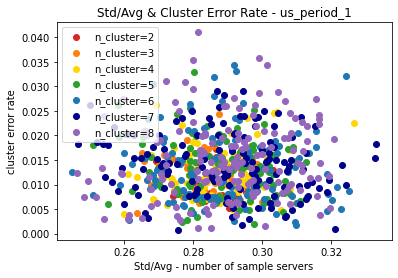

Figure 5.19: Cluster Error Rate and Std/Avg of Random Clustering Results - US-1


,n_cluster,err,mean_std/avg,max_std/avg,min_cluster_size,min_cluster_err
n_cluster,1.000000,0.232267,0.948263,0.730036,-0.923047,0.240673
err,0.232267,1.000000,0.190309,0.196376,-0.207143,-0.131777
mean_std/avg,0.948263,0.190309,1.000000,0.688373,-0.841281,0.237487
max_std/avg,0.730036,0.196376,0.688373,1.000000,-0.777663,0.162229
min_cluster_size,-0.923047,-0.207143,-0.841281,-0.777663,1.000000,-0.241109
min_cluster_err,0.240673,-0.131777,0.237487,0.162229,-0.241109,1.000000


In [60]:
# Figure 5.19: Cluster Error Rate and Std/Avg of Random Clustering Results - US-1

n_clusters = [2,3,4,5,6,7,8]
label_number_each_n_cluster = 20
cluster_err_up_limit = math.inf
print(f'cluster_err_up_limit: {cluster_err_up_limit}')

# dataFrame for each cluster (class)
data_cluster_df = pd.DataFrame(columns = ['n_cluster', 'cluster_err', 'std/avg', 'cluster_size'], index=list(range(label_number_each_n_cluster*(np.sum(n_clusters)))))

# dataFrame for each clustering result
data_df = pd.DataFrame(columns = ['n_cluster', 'err', 'mean_std/avg', 'max_std/avg', 'min_cluster_size', 'min_cluster_err'], index=list(range(7*label_number_each_n_cluster)))

if random_period_choose == 0:
    baseline_ip_sum = baseline_ip_sum_p0
    s_dbw_record = s_dbw_record_p0
elif random_period_choose == 1:
    baseline_ip_sum = baseline_ip_sum_p1
    s_dbw_record = s_dbw_record_p1

# min_class_size for each clustering result
min_class_size = []
err_record = []
min_cluster_bias_proportion = [] # np.mean(bias_class[min_cluster_index]/est_sum[min_cluster_index])
min_cluster_err = []

# err & std/avg for each clusters
mean_class_err_record = []
std_avg_sample_num_record = []
cluster_size_record = []
index = 0 # for dataFrame
for n_cluster in n_clusters:
    mean_class_err_record.append([])
    std_avg_sample_num_record.append([])
    cluster_size_record.append([])
    for label in range(label_number_each_n_cluster):
        # baseline number in class
        baseline_num_class, class_ip_index = baseline_class_random(data_period, n_cluster, label)
        baseline_num_class = np.array(baseline_num_class)
        
        # estimation number in class
        est_p, _ = r_label_2_p2_random(data_period, n_cluster, label)
        sum_ch, ch_in_class = get_p1_caputure_history_random(data_period, n_cluster, label)
        est_p, sum_ch = np.array(est_p), np.array(sum_ch)
        est_num_class = sum_ch[:, 1:] / est_p
        err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
        
        # total est number
        est_sum = np.sum(est_num_class, axis=0)
        class_sizes = []
        for _class in range(n_cluster):
            class_sizes.append(len(class_ip_index[_class]))
            if np.mean(err_class[_class]) > cluster_err_up_limit:
                continue
            mean_class_err_record[-1].append(np.mean(err_class[_class]))
            std_avg_sample_num_record[-1].append(np.std(sum_ch[_class])/np.mean(sum_ch[_class]))
            cluster_size_record[-1].append(len(class_ip_index[_class]))
            
            # dataFrame
            data_cluster_df['n_cluster'][index] = n_cluster
            data_cluster_df['cluster_err'][index] = mean_class_err_record[-1][-1]
            data_cluster_df['std/avg'][index] = std_avg_sample_num_record[-1][-1]
            data_cluster_df['cluster_size'][index] = len(class_ip_index[_class])
            index += 1
        min_class_size.append(min(class_sizes))
        err_record.append(np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2]))
        # bias in min cluster
        min_cluster_index = class_sizes.index(min(class_sizes))
        bias_class = np.abs(est_num_class[:,1:-2] - baseline_num_class[:,2:-2])
        nan_in_bias_class = False
        for bias in bias_class[min_cluster_index]:
            if np.isnan(bias):
                nan_in_bias_class = True
        if not nan_in_bias_class:
            min_cluster_bias_proportion.append(np.mean(bias_class[min_cluster_index]/est_sum[1:-2]))
            min_cluster_err.append(np.mean(err_class[min_cluster_index]))
        data_df_index = (n_cluster-2)*label_number_each_n_cluster + label
        data_df['n_cluster'][data_df_index] = n_cluster
        data_df['err'][data_df_index] = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
        data_df['mean_std/avg'][data_df_index] = np.mean(std_avg_sample_num_record[-1])
        data_df['max_std/avg'][data_df_index] = max(std_avg_sample_num_record[-1])
        data_df['min_cluster_size'][data_df_index] = min(class_sizes)
        data_df['min_cluster_err'][data_df_index] = np.mean(err_class[min_cluster_index])

# scatter plot - sample num std & err mean
pyplot.title(f'Std/Avg & Cluster Error Rate - {data_period}')
pyplot.xlabel('Std/Avg - number of sample servers')
pyplot.ylabel('cluster error rate')

colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

err_sum=0
err_num=0
for n_cluster in range(7):
    _cluster = n_cluster+2
    print(f'n_cluster: {_cluster}')
    pyplot.scatter(std_avg_sample_num_record[n_cluster], mean_class_err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
    err_num_class = 0
    for err_i in range(len(mean_class_err_record[n_cluster])):
        err = mean_class_err_record[n_cluster][err_i]
        if np.isnan(err):
            print(f'err is nan: {err_i}')
            continue
        err_sum += err
        err_num += 1
        err_num_class += 1
    print(f'err_num_class: {err_num_class}')
    
    
pyplot.legend()
pyplot.show()

print('Figure 5.19: Cluster Error Rate and Std/Avg of Random Clustering Results - US-1')
data_df.astype('float64').corr()